In [55]:
import pandas
import seaborn
import numpy

# TODO: ADD CORRELATION FOR TYPE OF HOME

data_raw = pandas.read_csv('austinHousingData.csv')

labelsToRemove = ['zpid', 'city', 'streetAddress', 'latitude', 'longitude', 'description', 'hasGarage', 'numPriceChanges', 'latest_saledate', 'latest_salemonth', 'latest_saleyear', 'latestPriceSource', 'numOfPhotos', 'homeImage']

data_raw.drop(labelsToRemove, axis=1, inplace=True)

floatColumns = numpy.asarray(data_raw.select_dtypes(include=['float64']).columns).tolist()
boolColumns = numpy.asarray(data_raw.select_dtypes(include=['bool']).columns).tolist()
intColumns = numpy.asarray(data_raw.select_dtypes(include=['int64']).columns).tolist()

floatData = pandas.merge(pandas.DataFrame(data_raw.latestPrice), data_raw.drop(boolColumns + intColumns, axis=1), right_index=True, left_index=True)
boolData = pandas.merge(pandas.DataFrame(data_raw.latestPrice), data_raw.drop(floatColumns + intColumns, axis=1), right_index=True, left_index=True)
intData = data_raw.drop(boolColumns + floatColumns, axis=1)



Heatmap for Float64 values and latestPrice


<AxesSubplot:>

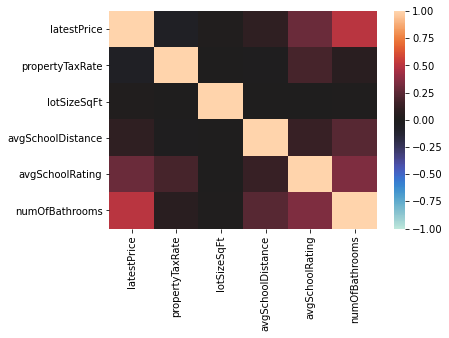

In [52]:
print("Heatmap for Float64 values and latestPrice")
seaborn.heatmap(floatData.corr(), vmin=-1, vmax=1, center=0, annot=False)

Heatmap for bool values and latestPrice


<AxesSubplot:>

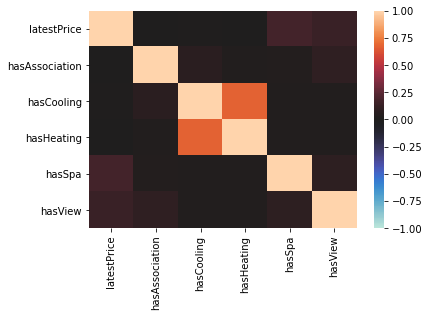

In [53]:
print("Heatmap for bool values and latestPrice")
seaborn.heatmap(boolData.corr(), vmin=-1, vmax=1, center=0, annot=False)


Heatmap for int values and latestPrice


<AxesSubplot:>

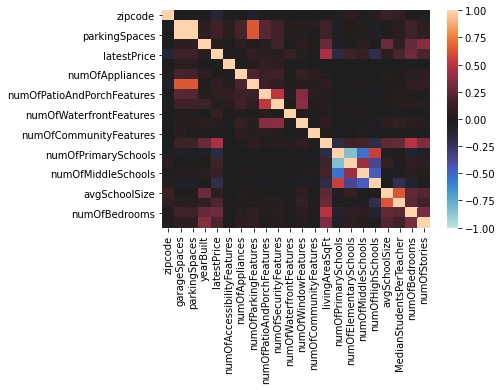

In [54]:

print("Heatmap for int values and latestPrice")
seaborn.heatmap(intData.corr(), vmin=-1, vmax=1, center=0, annot=False)